In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:

def load_and_index_lead(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
    return df

In [3]:
def drop_high_na_buildings(df: pd.DataFrame, threshold: float = 0.80) -> pd.DataFrame:
    """
    Drop buildings whose 'meter_reading' column has more than a specified fraction of missing values.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with 'building_id', 'meter_reading', etc.
    threshold : float, optional
        Maximum allowable NaN fraction per building.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with low-NaN buildings retained.
    """
    retained = []
    drop_count = 0

    for b_id, group in df.groupby("building_id"):
        na_ratio = group["meter_reading"].isna().mean()
        if na_ratio <= threshold:
            retained.append(group)
        else:
            drop_count += 1

    if not retained:
        raise ValueError("All buildings exceed the NaN threshold. No data to return.")

    result_df = pd.concat(retained, axis=0)
    print(f"Dropped {drop_count} buildings with >{threshold:.0%} NaNs. Retained {result_df['building_id'].nunique()} buildings.")
    return result_df


In [4]:
def kalman_smoother_impute(series: pd.Series) -> pd.Series:
    series = series.sort_index().asfreq('H')
    model = SARIMAX(series, order=(1, 0, 0), initialization='approximate_diffuse')
    fitted = model.fit(disp=False)
    predicted = fitted.predict(start=series.index[0], end=series.index[-1])
    return series.combine_first(predicted)

In [5]:
def na_seadec_impute(series: pd.Series, period: int = 24, robust: bool = True) -> pd.Series:
    s = series.sort_index().asfreq('H')
    prefilled = kalman_smoother_impute(s)
    stl = STL(prefilled, period=period, robust=robust)
    res = stl.fit()
    trend, seasonal = res.trend, res.seasonal
    resid = prefilled - trend - seasonal
    resid_interp = resid.interpolate(method='time')
    filled = prefilled.copy()
    mask = s.isna()
    reconstruction = trend + seasonal + resid_interp
    filled.loc[mask] = reconstruction.loc[mask]
    return filled


In [6]:
def find_nan_blocks(series: pd.Series) -> pd.DataFrame:
    series = series.sort_index()
    is_nan = series.isna()
    change = is_nan.ne(is_nan.shift()).cumsum()
    groups = is_nan.groupby(change)
    records = []
    for k, v in groups:
        if v.iloc[0]:
            records.append({
                "start": v.index[0],
                "end":   v.index[-1],
                "length": len(v)
            })
    return pd.DataFrame(records, columns=["start", "end", "length"]).sort_values("start")

In [7]:
from tqdm import tqdm
import pandas as pd

def clip_and_filter_lead_buildings(df: pd.DataFrame,
                                   short_valid_threshold: int = 48) -> pd.DataFrame:
    """
    Applies robust clipping and filtering to a LEAD-style dataset.

    This function:
    1. Clips leading/trailing NaNs per building (retains only the main valid block).
    2. Within that block, removes very short valid sequences that appear between long NaN gaps.

    Parameters
    ----------
    df : pd.DataFrame
        LEAD-format DataFrame with ['timestamp', 'building_id', 'meter_reading'].
    short_valid_threshold : int, default 48
        Maximum number of hours a valid segment must have to be retained.
        If a valid segment between NaN blocks is shorter than surrounding NaNs, it will be removed.

    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame with clipped and filtered meter readings per building.

    Example
    -------
    >>> df_clean = clip_and_filter_lead_buildings(raw_df)
    """
    clipped_buildings = []

    for b_id in tqdm(df["building_id"].unique(), desc="Clipping & filtering per building"):
        group = df[df["building_id"] == b_id].copy()
        group = group.sort_values("timestamp").set_index("timestamp")

        s = group["meter_reading"]

        # 1. Clip outer NaNs
        start_idx, end_idx = s.first_valid_index(), s.last_valid_index()
        if not (start_idx and end_idx):
            continue  # skip all-NaN buildings
        s = s.loc[start_idx:end_idx]

        # 2. Filter short valid blocks
        blocks = find_nan_blocks(s)
        to_nan = []
        for i in range(1, len(blocks)):
            prev_end = blocks.iloc[i - 1]["end"]
            next_start = blocks.iloc[i]["start"]
            in_between = s[prev_end:next_start]
            if in_between.isna().sum() == 0:
                duration = (next_start - prev_end) / pd.Timedelta(hours=1)
                if duration < blocks.iloc[i - 1]["length"] or duration < blocks.iloc[i]["length"]:
                    to_nan.extend(in_between.index)

        s.loc[to_nan] = pd.NA
        s = s.loc[s.first_valid_index():s.last_valid_index()]  # Re-clip after setting to NaN

        # Recombine with group
        group = group.loc[s.index]
        group["meter_reading"] = s
        group["building_id"] = b_id
        clipped_buildings.append(group.reset_index())

    return pd.concat(clipped_buildings).sort_values(["building_id", "timestamp"])


In [8]:
def impute_meter_readings(df: pd.DataFrame,
                          threshold: int = 48,
                          period: int = 24) -> pd.DataFrame:
    """
    Apply two-tiered imputation to the 'meter_reading' column for each building:
    - Gaps of length ≤ `threshold` are imputed using Kalman Smoother.
    - Gaps longer than `threshold` are imputed using Seasonal Decomposition + Interpolation.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame in LEAD format with ['timestamp', 'building_id', 'meter_reading'].
    threshold : int, default 48
        Gap-length cutoff (in hours). Gaps ≤ threshold → Kalman, > threshold → STL.
    period : int, default 24
        Seasonal period for STL decomposition (e.g., 24 for daily cycle in hourly data).

    Returns
    -------
    pd.DataFrame
        DataFrame with imputed meter readings, sorted by building and timestamp.
    """
    filled_buildings = []

    for b_id, group in tqdm(df.groupby("building_id"), desc="Imputing per building"):
        s = group.sort_values("timestamp").set_index("timestamp")["meter_reading"].asfreq("H")
        blocks = find_nan_blocks(s)
        s_filled = s.copy()

        for _, row in blocks.iterrows():
            gap_len = row["length"]
            gap_slice = slice(row["start"], row["end"])

            if gap_len <= threshold:
                # Use Kalman for shorter gaps
                s_filled.loc[gap_slice] = kalman_smoother_impute(s).loc[gap_slice]
            else:
                # Use Seasonal decomposition for longer gaps
                s_filled.loc[gap_slice] = na_seadec_impute(s, period=period).loc[gap_slice]

        filled = group.copy()
        filled = filled.set_index("timestamp")
        filled["meter_reading"] = s_filled
        filled_buildings.append(filled.reset_index())

    return pd.concat(filled_buildings).sort_values(["building_id", "timestamp"])


In [9]:
def longest_contiguous_valid_block(series: pd.Series) -> pd.Series:
    is_valid = ~series.isna()
    grp = (is_valid != is_valid.shift()).cumsum()
    groups = series.groupby(grp)
    lengths = groups.apply(lambda x: x.notna().sum())
    valid_groups = lengths[lengths == lengths.max()]
    max_grp_id = valid_groups.index[0]
    return groups.get_group(max_grp_id)

In [10]:
def plot_imputation_result(original_df: pd.DataFrame,
                           imputed_df: pd.DataFrame,
                           building_id: int,
                           start: str = None,
                           end: str = None,
                           figsize=(16, 6)) -> None:
    """
    Plot original and imputed meter readings for a specific building, highlighting filled NaNs.

    Parameters
    ----------
    original_df : pd.DataFrame
        Original dataframe before imputation.
    imputed_df : pd.DataFrame
        Imputed dataframe after filling.
    building_id : int
        The building ID to visualize.
    start : str, optional
        Start timestamp for zooming into a particular period.
    end : str, optional
        End timestamp for zooming into a particular period.
    figsize : tuple
        Size of the plot.

    Returns
    -------
    None
        Displays the plot.
    """
    orig = original_df[original_df["building_id"] == building_id].set_index("timestamp").sort_index()
    imp = imputed_df[imputed_df["building_id"] == building_id].set_index("timestamp").sort_index()

    # Auto zoom if not provided
    if (start is None or end is None) and not orig["meter_reading"].dropna().empty:
        start, end = orig["meter_reading"].dropna().index[0], orig["meter_reading"].dropna().index[-1]

    if start and end:
        orig = orig.loc[start:end]
        imp = imp.loc[start:end]

    # Identify NaN positions
    nan_mask = orig["meter_reading"].isna()

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(orig.index, orig["meter_reading"], label="Original", color="red", alpha=0.5,
            marker='o', linestyle='None')
    ax.plot(imp.index, imp["meter_reading"], label="Imputed", color="blue", alpha=0.7)

    # Highlight NaN-fills
    ax.plot(orig.index[nan_mask],
            imp.loc[nan_mask, "meter_reading"],
            marker='x', linestyle='None', color='green', label="Filled NaNs")

    ax.set_title(f"Building ID {building_id} - Original vs Imputed")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Meter Reading (kWh)")
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(f"imputation_result_building_{building_id}.png", dpi=300)

In [11]:
def save_imputed_df(imputed_df: pd.DataFrame, output_path: str = "lead_train_imputed.csv") -> None:
    """
    Save the imputed DataFrame to CSV in the LEAD dataset format.

    Parameters
    ----------
    imputed_df : pd.DataFrame
        The final imputed dataframe.
    output_path : str
        Path to save the CSV file.

    Returns
    -------
    None
    """
    cols = ["building_id", "timestamp", "meter_reading", "anomaly"]
    imputed_df[cols].to_csv(output_path, index=False)
    print(f"Imputed dataset saved to: {output_path}")

In [12]:
def convert_bdg2_to_lead_format(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts a wide-format dataframe with timestamps as index and building columns
    to long-format LEAD-compatible format with numeric building IDs.

    Parameters
    ----------
    df : pd.DataFrame
        Wide-format DataFrame with:
        - Index as timestamp (or a column named 'timestamp')
        - Columns as building names/IDs (can be strings or numbers)

    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        ['timestamp', 'building_id', 'meter_reading', 'anomaly']

    Example
    -------
    Input:
        timestamp   Building_A   Building_B
        2020-01-01    23.1         45.0

    Output:
        timestamp            building_id  meter_reading  anomaly
        2020-01-01 00:00:00+00:00    1          23.1            0
        2020-01-01 00:00:00+00:00    2          45.0            0
    """
    # If timestamp is in index, reset it to a column
    if df.index.name == 'timestamp' or df.index.inferred_type == 'datetime64':
        df = df.reset_index()

    # Melt the wide format: timestamp, building1, building2, ... → timestamp, building_id, meter_reading
    long_df = df.melt(id_vars=['timestamp'], var_name='building_name', value_name='meter_reading')

    # Convert building names to categorical codes → numeric IDs
    long_df['building_id'] = long_df['building_name'].astype('category').cat.codes + 1

    # Drop original building name
    long_df.drop(columns='building_name', inplace=True)

    # Ensure timestamp is datetime with UTC (optional based on your preference)
    long_df['timestamp'] = pd.to_datetime(long_df['timestamp'], utc=True, errors='coerce')

    # Add anomaly column initialized to 0
    long_df['anomaly'] = 0

    # Reorder columns
    long_df = long_df[['timestamp', 'building_id', 'meter_reading', 'anomaly']]

    return long_df

In [13]:
# Load and preprocess
electricity_df = load_and_index_lead("electricity_cleaned.csv")
# Convert to LEAD format if needed
electricity_df = convert_bdg2_to_lead_format(electricity_df)
electricity_df = drop_high_na_buildings(electricity_df)
clipped_df = clip_and_filter_lead_buildings(electricity_df)
# Impute missing values
imputed_df = impute_meter_readings(clipped_df)




Dropped 25 buildings with >80% NaNs. Retained 1553 buildings.


Imputing per building:  39%|███▉      | 606/1553 [2:06:20<2:35:20,  9.84s/it]  /data1/home/nitinvetcha/miniconda3/envs/tsfm_anomaly/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data1/home/nitinvetcha/miniconda3/envs/tsfm_anomaly/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data1/home/nitinvetcha/miniconda3/envs/tsfm_anomaly/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/data1/home/nitinvetcha/miniconda3/envs/tsfm_anomaly/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarni

In [14]:
imputed_df.head(5)

,timestamp,building_id,meter_reading,anomaly
0,2016-01-01 00:00:00+00:00,1,237.85,0
1,2016-01-01 01:00:00+00:00,1,221.25,0
2,2016-01-01 02:00:00+00:00,1,222.50,0
3,2016-01-01 03:00:00+00:00,1,221.40,0
4,2016-01-01 04:00:00+00:00,1,224.25,0


In [15]:
def plot_imputed_vs_original_with_table(original_df: pd.DataFrame,
                                        imputed_df: pd.DataFrame,
                                        building_id: int,
                                        start: str = None,
                                        end: str = None,
                                        max_rows: int = 10,
                                        figsize=(16, 10)) -> None:
    """
    Plot original and imputed meter readings for a specific building,
    highlight imputed values, and show a table of differences.

    Parameters
    ----------
    original_df : pd.DataFrame
        Original dataframe with NaNs in 'meter_reading'.
    imputed_df : pd.DataFrame
        Imputed dataframe with filled 'meter_reading'.
    building_id : int
        Building to plot.
    start : str, optional
        Start timestamp.
    end : str, optional
        End timestamp.
    max_rows : int, default 10
        Max rows to show in the table.
    figsize : tuple, default (16, 10)
        Size of the combined figure.
    """
    # Filter and align data
    orig = original_df[original_df["building_id"] == building_id].set_index("timestamp").sort_index()
    imp = imputed_df[imputed_df["building_id"] == building_id].set_index("timestamp").sort_index()

    orig.index = pd.to_datetime(orig.index)
    imp.index = pd.to_datetime(imp.index)

    if start and end:
        orig = orig.loc[start:end]
        imp = imp.loc[start:end]

    # Identify imputed points
    imputed_mask = orig["meter_reading"].isna() & imp["meter_reading"].notna()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [3, 1]})

    # Plot full imputed series
    ax1.plot(imp.index, imp["meter_reading"], label="Imputed (Full)", color="blue", alpha=0.6)

    # Highlight imputed values
    ax1.plot(imp.loc[imputed_mask].index,
             imp.loc[imputed_mask]["meter_reading"],
             'o', label="Imputed Points", color="red", markersize=6)

    ax1.set_title(f"Building ID {building_id} – Imputed vs Original Readings")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Meter Reading (kWh)")
    ax1.legend()
    ax1.grid(True)

    # Create a table of imputed values
    if imputed_mask.sum() > 0:
        comp_df = pd.DataFrame({
            "Timestamp": imp.loc[imputed_mask].index.strftime("%Y-%m-%d %H:%M"),
            "Imputed Value": imp.loc[imputed_mask, "meter_reading"].round(3)
        })
        comp_df = comp_df.head(max_rows)

        ax2.axis("off")
        table = ax2.table(cellText=comp_df.values,
                          colLabels=comp_df.columns,
                          loc='center',
                          cellLoc='center')
        table.scale(1, 1.5)
        table.auto_set_font_size(False)
        table.set_fontsize(10)
    else:
        ax2.text(0.5, 0.5, "No imputed values in this window", ha="center", va="center", fontsize=12)
        ax2.axis("off")

    plt.tight_layout()
    plt.show()

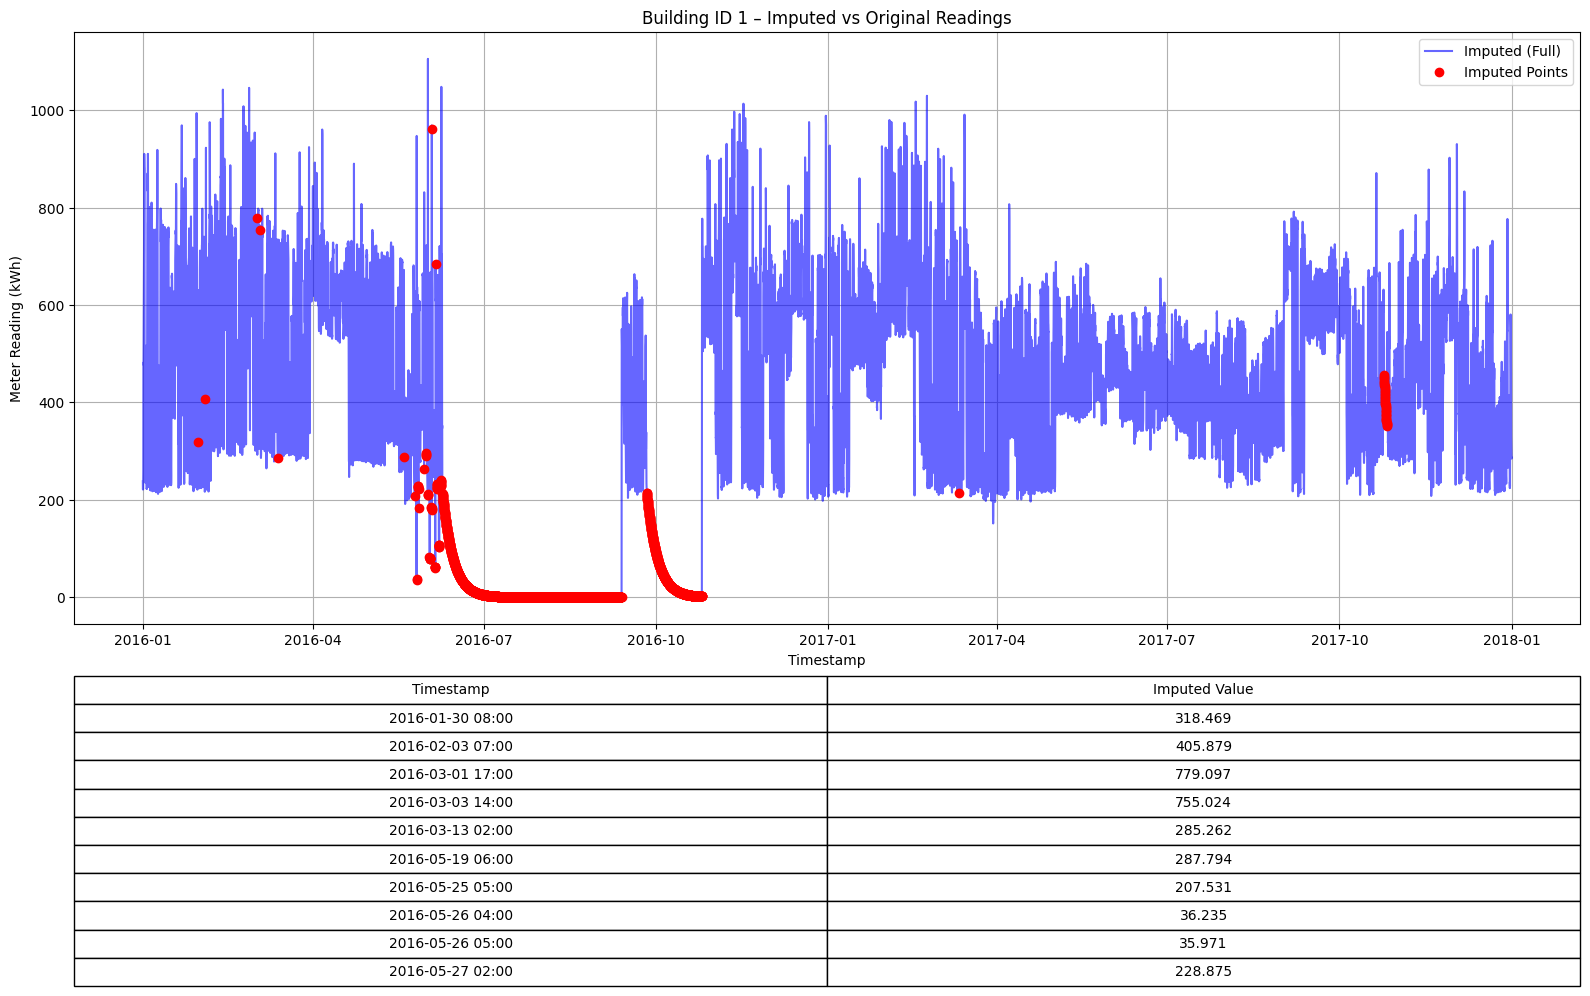

In [19]:
plot_imputed_vs_original_with_table(electricity_df, imputed_df, building_id=1)

In [17]:
# Save the final imputed DataFrame
save_imputed_df(imputed_df, "electricity_cleaned_imputed.csv")

Imputed dataset saved to: electricity_cleaned_imputed.csv


In [ ]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Optional

def plot_imputed_vs_original_lead_comparison(
    original_df: pd.DataFrame,
    imputed_df: pd.DataFrame,
    building_id: int,
    output_html_path: Optional[str] = None,
    color_scale: str = "Turbo"
):
    """
    Creates a side-by-side interactive heatmap comparing original vs imputed meter readings.

    Parameters
    ----------
    original_df : pd.DataFrame
        DataFrame containing the original readings. Requires ['building_id', 'timestamp', 'meter_reading'].
    imputed_df : pd.DataFrame
        DataFrame containing imputed readings. Requires ['building_id', 'timestamp', 'meter_reading'].
    building_id : int
        Building ID to filter for.
    output_html_path : str, optional
        If provided, saves the plot to this HTML file.
    color_scale : str
        Plotly colorscale to use (default: "Turbo").

    Returns
    -------
    plotly.graph_objects.Figure
        The generated interactive heatmap figure.
    """
    # Filter building
    orig = original_df[original_df['building_id'] == building_id].copy()
    imp = imputed_df[imputed_df['building_id'] == building_id].copy()

    # Convert timestamp to datetime with consistent timezone handling
    orig['timestamp'] = pd.to_datetime(orig['timestamp'], utc=True).dt.tz_localize(None)
    imp['timestamp'] = pd.to_datetime(imp['timestamp'], utc=True).dt.tz_localize(None)

    # Merge on standardized timestamps
    df = pd.merge(
        orig[['timestamp', 'meter_reading']],
        imp[['timestamp', 'meter_reading']],
        on='timestamp',
        how='inner',
        suffixes=('_original', '_imputed')
    )

    df['hour'] = df['timestamp'].dt.hour
    df['day_of_year'] = df['timestamp'].dt.dayofyear
    df['timestamp_str'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

    # Create pivot tables
    pivot_orig = df.pivot(index='hour', columns='day_of_year', values='meter_reading_original')
    pivot_imp = df.pivot(index='hour', columns='day_of_year', values='meter_reading_imputed')
    pivot_hover = df.pivot(index='hour', columns='day_of_year', values='timestamp_str')

    # Hover data
    hover_data = []
    for h in pivot_orig.index:
        row = []
        for d in pivot_orig.columns:
            ts = pivot_hover.at[h, d] if (h in pivot_hover.index and d in pivot_hover.columns) else "N/A"
            o_val = pivot_orig.at[h, d] if pd.notna(pivot_orig.at[h, d]) else np.nan
            i_val = pivot_imp.at[h, d] if pd.notna(pivot_imp.at[h, d]) else np.nan

            if pd.isna(o_val) or pd.isna(i_val):
                row.append(f"Timestamp: {ts}<br>Original: N/A<br>Imputed: N/A")
            else:
                row.append(f"Timestamp: {ts}<br>Original: {o_val:.2f}<br>Imputed: {i_val:.2f}")
        hover_data.append(row)

    zmin = np.nanmin([pivot_orig.values.min(), pivot_imp.values.min()])
    zmax = np.nanmax([pivot_orig.values.max(), pivot_imp.values.max()])

    # Create subplots
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=["Original Meter Readings", "Imputed Meter Readings"],
        shared_yaxes=True
    )

    fig.add_trace(
        go.Heatmap(
            z=pivot_orig.values,
            x=pivot_orig.columns,
            y=pivot_orig.index,
            colorscale=color_scale,
            zmin=zmin,
            zmax=zmax,
            hovertemplate="Hour: %{y}:00<br>Day: %{x}<br>Original: %{z:.2f}<extra></extra>"
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Heatmap(
            z=pivot_imp.values,
            x=pivot_imp.columns,
            y=pivot_imp.index,
            colorscale=color_scale,
            zmin=zmin,
            zmax=zmax,
            customdata=np.array(hover_data),
            hovertemplate="%{customdata}<extra></extra>"
        ),
        row=1, col=2
    )

    fig.update_layout(
        title_text=f"📊 Building {building_id}: Original vs Imputed Hourly Heatmap",
        width=1400,
        height=500,
        margin=dict(t=60, l=50, r=50, b=50)
    )

    fig.update_xaxes(title_text="Day of Year", row=1, col=1)
    fig.update_xaxes(title_text="Day of Year", row=1, col=2)
    fig.update_yaxes(title_text="Hour of Day", tickmode='array', tickvals=list(range(0, 24, 2)))

    if output_html_path:
        fig.write_html(output_html_path)
        print(f"✅ Saved heatmap to: {output_html_path}")

    fig.show()
    return fig


In [3]:
original_df = pd.read_csv("LEAD.csv")
imputed_df = pd.read_csv("lead_train_imputed.csv")

plot_imputed_vs_original_lead_comparison(
    original_df=original_df,
    imputed_df=imputed_df,
    building_id=1,
    output_html_path="original_vs_imputed_heatmap_building_1.html"
)

ValueError: You are trying to merge on datetime64[ns] and datetime64[ns, UTC] columns. If you wish to proceed you should use pd.concat